In [ ]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import IPython.display as ipd
import librosa as lib
import librosa.display
import wave

In [ ]:
set_a_load="/content/drive/MyDrive/archive/set_a.csv"

In [ ]:
set_a=pd.read_csv(set_a_load)

In [ ]:
set_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [ ]:
filtered_set_a = set_a[set_a['label'].isin(['murmur', 'normal'])].copy()
filtered_set_a['label'] = filtered_set_a['label'].replace('normal', 'non murmur')
filtered_set_a=filtered_set_a[['fname', 'label']]
filtered_set_a

,fname,label
59,set_a/murmur__201101051104.wav,murmur
60,set_a/murmur__201101051108.wav,murmur
61,set_a/murmur__201101051114.wav,murmur
62,set_a/murmur__201101180902.wav,murmur
63,set_a/murmur__201102051443.wav,murmur
...,...,...
119,set_a/normal__201106221450.wav,non murmur
120,set_a/normal__201108011112.wav,non murmur
121,set_a/normal__201108011114.wav,non murmur
122,set_a/normal__201108011115.wav,non murmur


In [ ]:
filtered_set_a.groupby(['label']).count()

,fname
label,
murmur,34
non murmur,31


In [ ]:
ipd.Audio(r"/content/drive/MyDrive/archive/set_b/normal__177_1307989650056_D1.wav")

In [ ]:
import wave

In [ ]:
wav=wave.open(r'/content/drive/MyDrive/archive/set_a/normal__201106111136.wav')
framerate=wav.getframerate()
print(framerate)
framesize=wav.getnframes()
print(framesize)
duration = framesize / framerate
print(duration)

44100
218903
4.963786848072562


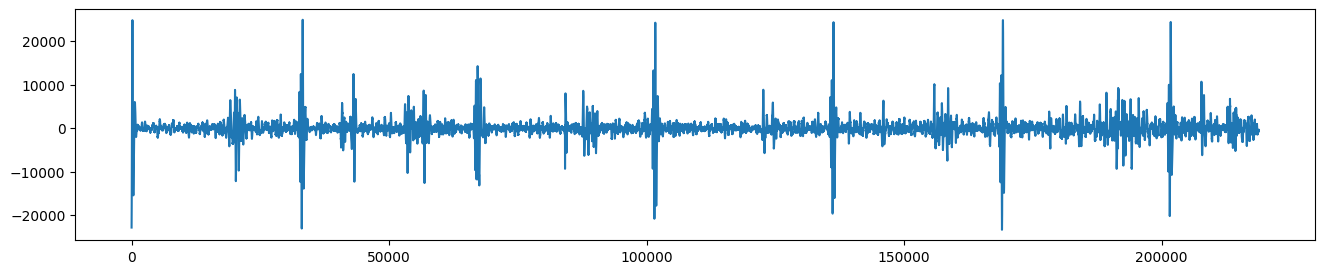

In [ ]:
from scipy.io import wavfile
rate,data=wavfile.read(r'/content/drive/MyDrive/archive/set_a/normal__201106111136.wav')
plt.figure(figsize=(16, 3))
plt.plot(data,'-',)
plt.show()

Original sample rate: 22050
Resampled sample rate: 16000
Original audio shape: (195894,)
Resampled audio shape: (142146,)


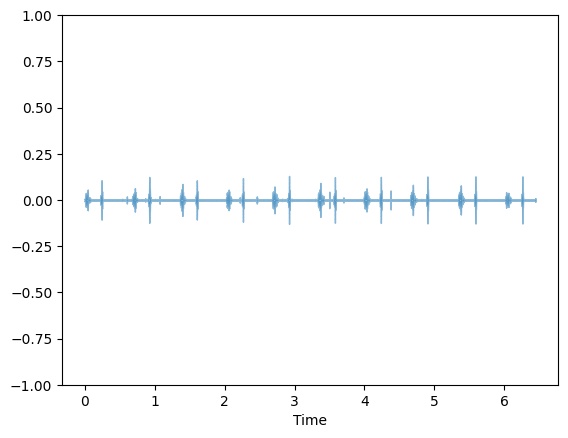

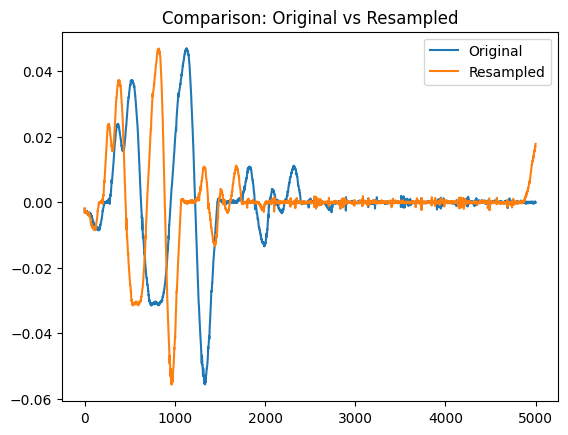

In [ ]:
audio, original_sr = lib.load(r'/content/drive/MyDrive/archive/set_a/murmur__201101051108.wav')

# Resample the audio to 16000 Hz
target_sr = 16000
resampled_audio = lib.resample(audio, orig_sr=original_sr, target_sr=target_sr)

print(f"Original sample rate: {original_sr}")
print(f"Resampled sample rate: {target_sr}")
print(f"Original audio shape: {audio.shape}")
print(f"Resampled audio shape: {resampled_audio.shape}")
librosa.display.waveshow(resampled_audio,alpha=0.5)
plt.ylim(-1,1)
plt.show()
plt.plot(audio[:5000], label='Original')
plt.plot(resampled_audio[:5000], label='Resampled')
plt.legend()
plt.title("Comparison: Original vs Resampled")
plt.show()

Number of samples=sampling Rate(Hz)*Duration(seconds)

frame=⌊(no_of sample-frame_length/frame step)⌋+1

freq_bins=frame_length//2+1

avd duration of clips=4.3sec

no_sample=4.3*16000=68800samples

Use common window values (standard for speech/audio):

frame length = 25 ms 0.025 × 16000 = 400 samples

frame step = 10 ms 0.010 × 16000 = 160 samples


In [ ]:
def extract_logmel(file_path):
  target_sr=16000
  audio, sr = librosa.load(file_path)
  resampled_audio = lib.resample(audio, orig_sr=sr, target_sr=target_sr)
  S = librosa.feature.melspectrogram(y=resampled_audio, n_mels=128, fmax=8000)
  log_mel = librosa.power_to_db(S, ref=np.max)
  if log_mel.shape[1] < 300:
        pad_width = 300 - log_mel.shape[1]
        log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), mode='constant')
  else:
      log_mel = log_mel[:, :300]
  return log_mel

In [ ]:
LABEL_MAP = {'non murmur': 0, 'murmur': 1}
X=[]
y=[]
for index, row in filtered_set_a.iterrows():
    #print(f"Processing file: {row['fname']},{row['label']}")
    file_path = f"/content/drive/MyDrive/archive/{row['fname']}"
    logmel=extract_logmel(file_path)
    X.append(logmel[..., np.newaxis])#
    y.append(LABEL_MAP[row['label']])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)
print(X.shape)
print(y.shape)

(65, 128, 300, 1)
(65,)


In [ ]:
np.save('/content/sample_data/X.npy',X)
np.save('/content/sample_data/y.npy',y)

# LeNet5 Architecture

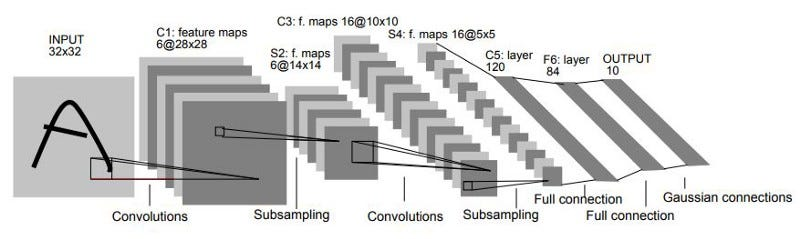

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

class LeNet5(nn.Module):
  def __init__(self,num_classes=2):
    super(LeNet5,self).__init__()

    self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
    self.pool1=nn.AvgPool2d(kernel_size=2,stride=2)

    self.conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
    self.pool2=nn.AvgPool2d(kernel_size=2,stride=2)

    self.conv3=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)

    self.fc1=nn.Linear(in_features=120 * 25 * 93,out_features=84)
    self.fc2=nn.Linear(in_features=84,out_features=num_classes)

  def forward(self,x):
    out=F.relu(self.conv1(x))
    out=self.pool1(out)

    out=F.relu(self.conv2(out))
    out=self.pool2(out)

    out=F.relu(self.conv3(out))

    out=out.reshape(out.size(0),-1)

    out=F.relu(self.fc1(out))
    out=self.fc2(out)
    return out

In [ ]:
X=np.load('/content/sample_data/X.npy')
y=np.load('/content/sample_data/y.npy')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#normalization
X = X.astype(np.float32)
for i in range(X.shape[0]):
    max_val = np.max(X[i])
    if max_val > 0:
        X[i] = X[i] / max_val

X = np.transpose(X, (0, 3, 1, 2))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)


In [ ]:
# Model, Loss, Optimizer
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
dummy = torch.randn(1, 1, 128, 300)
out = model.conv1(dummy)
out = model.pool1(out)
out = model.conv2(out)
out = model.pool2(out)
out = model.conv3(out)
print(out.shape)

torch.Size([1, 120, 25, 68])


Epoch [1/15], Loss: 746.9758, Accuracy: 46.15%
Epoch [2/15], Loss: 311.1123, Accuracy: 51.92%
Epoch [3/15], Loss: 167.2829, Accuracy: 48.08%
Epoch [4/15], Loss: 13.8381, Accuracy: 48.08%
Epoch [5/15], Loss: 1.3867, Accuracy: 59.62%
Epoch [6/15], Loss: 1.8624, Accuracy: 67.31%
Epoch [7/15], Loss: 4.1700, Accuracy: 50.00%
Epoch [8/15], Loss: 1.5467, Accuracy: 67.31%
Epoch [9/15], Loss: 2.0821, Accuracy: 59.62%
Epoch [10/15], Loss: 0.8952, Accuracy: 78.85%
Epoch [11/15], Loss: 1.0872, Accuracy: 78.85%
Epoch [12/15], Loss: 1.0610, Accuracy: 80.77%
Epoch [13/15], Loss: 0.8888, Accuracy: 80.77%
Epoch [14/15], Loss: 0.8794, Accuracy: 82.69%
Epoch [15/15], Loss: 0.8593, Accuracy: 80.77%


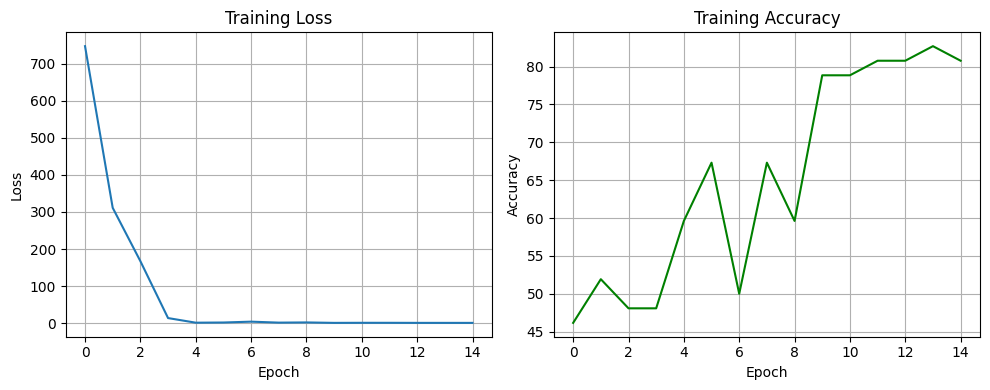

In [ ]:
num_epochs = 15
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    train_losses.append(total_loss)
    train_accuracies.append(acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

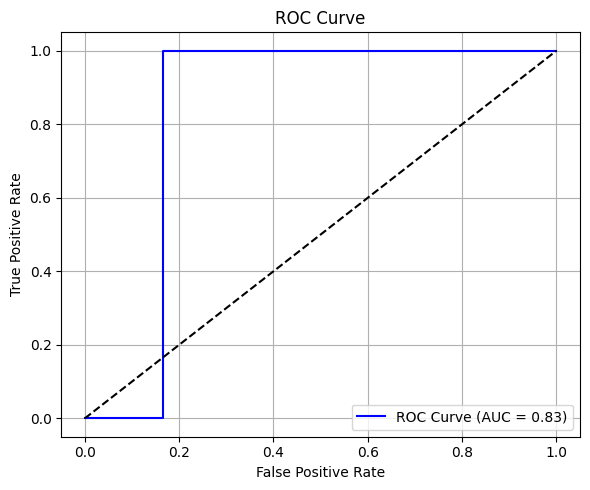


Sensitivity (Recall): 1.0000
Specificity         : 0.5000

Confusion Matrix:
 [[3 3]
 [0 7]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       1.00      0.50      0.67         6
      murmur       0.70      1.00      0.82         7

    accuracy                           0.77        13
   macro avg       0.85      0.75      0.75        13
weighted avg       0.84      0.77      0.75        13



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())  # ✅ only this line for labels

        probs = F.softmax(outputs, dim=1)[:, 1]   # Prob of class 1
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# ROC and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Metrics
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['non murmur', 'murmur'])
TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # also recall
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # true negative rate

print(f"\nSensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity         : {specificity:.4f}")

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Lenet1 Architecture

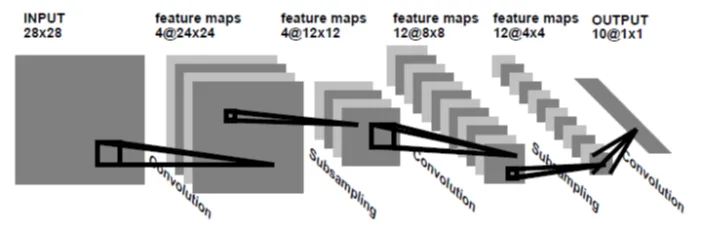

In [ ]:
class LeNet1(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(LeNet1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5)  # (4, 124, 396)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)                    # (4, 62, 198)
        self.dropout1 = nn.Dropout(dropout_rate)                              # Dropout after pooling

        self.fc1 = nn.Linear(4 * 62 * 198, 84)
        self.dropout2 = nn.Dropout(dropout_rate)                              # Dropout after FC1
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)  # Dropout after conv-pool

        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.dropout2(x)      # Dropout after FC
        x = self.fc2(x)
        return x

In [ ]:
X=np.load('/content/sample_data/X.npy')
y=np.load('/content/sample_data/y.npy')

In [ ]:
X = X.astype(np.float32)
for i in range(X.shape[0]):
    max_val = np.max(X[i])
    if max_val > 0:
        X[i] = X[i] / max_val

X = np.transpose(X, (0, 3, 1, 2))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet1(num_classes=2).to(device)

# 6. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005, weight_decay=1e-5)

Epoch [1/20], Loss: 230.8709, Accuracy: 44.23%
Epoch [2/20], Loss: 161.3634, Accuracy: 42.31%
Epoch [3/20], Loss: 201.1621, Accuracy: 53.85%
Epoch [4/20], Loss: 117.9133, Accuracy: 55.77%
Epoch [5/20], Loss: 23.7855, Accuracy: 57.69%
Epoch [6/20], Loss: 67.0689, Accuracy: 50.00%
Epoch [7/20], Loss: 82.4471, Accuracy: 46.15%
Epoch [8/20], Loss: 26.5500, Accuracy: 63.46%
Epoch [9/20], Loss: 40.3881, Accuracy: 59.62%
Epoch [10/20], Loss: 49.5934, Accuracy: 53.85%
Epoch [11/20], Loss: 38.9613, Accuracy: 59.62%
Epoch [12/20], Loss: 14.1250, Accuracy: 63.46%
Epoch [13/20], Loss: 9.2343, Accuracy: 65.38%
Epoch [14/20], Loss: 21.0210, Accuracy: 59.62%
Epoch [15/20], Loss: 14.0887, Accuracy: 53.85%
Epoch [16/20], Loss: 8.9178, Accuracy: 63.46%
Epoch [17/20], Loss: 4.2977, Accuracy: 65.38%
Epoch [18/20], Loss: 1.9874, Accuracy: 76.92%
Epoch [19/20], Loss: 1.8816, Accuracy: 63.46%
Epoch [20/20], Loss: 2.2586, Accuracy: 63.46%


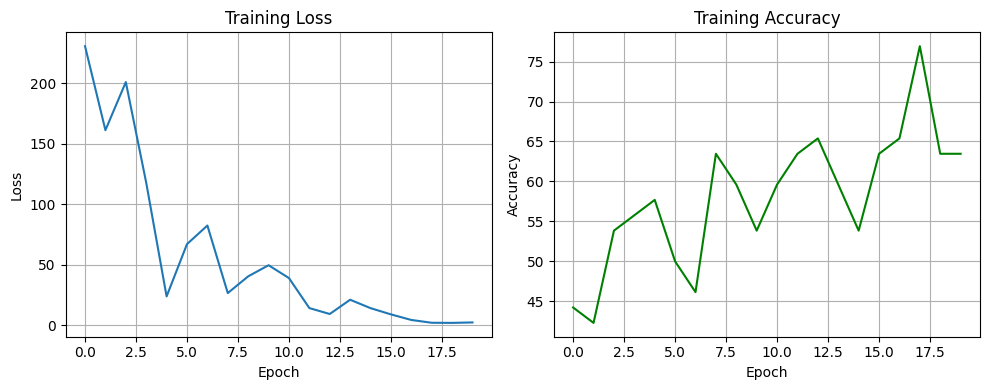

In [ ]:
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    train_losses.append(total_loss)
    train_accuracies.append(acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

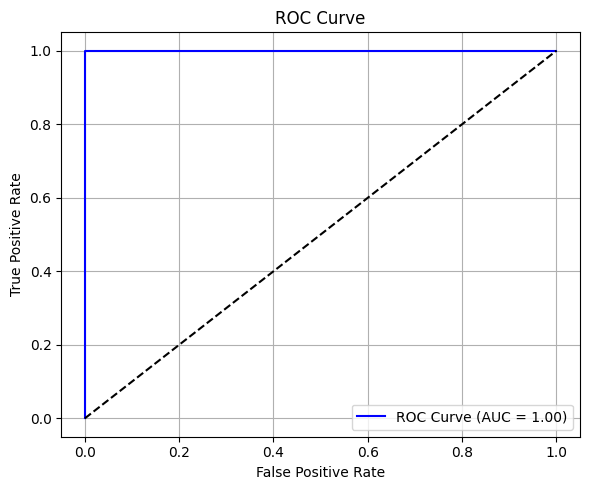


Sensitivity (Recall): 1.0000
Specificity         : 0.0000

 Confusion Matrix:
 [[0 6]
 [0 7]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       0.00      0.00      0.00         6
      murmur       0.54      1.00      0.70         7

    accuracy                           0.54        13
   macro avg       0.27      0.50      0.35        13
weighted avg       0.29      0.54      0.38        13



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 8. Evaluation on validation set
from sklearn.metrics import roc_curve, auc, roc_auc_score

model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())  # ✅ only this line for labels

        probs = F.softmax(outputs, dim=1)[:, 1]   # Prob of class 1
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# ROC and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
# 9. Metrics
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['non murmur', 'murmur'])
TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # also recall
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # true negative rate

print(f"\nSensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity         : {specificity:.4f}")

print("\n Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# **USing K-Fold Cross Validation**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [ ]:
X = np.load('/content/sample_data/X.npy')
print(X.shape)
y = np.load('/content/sample_data/y.npy')

(65, 128, 300, 1)


In [ ]:
# Normalize and reshape for PyTorch
X = X.astype(np.float32)
for i in range(X.shape[0]):
    max_val = np.max(X[i])
    if max_val > 0:
        X[i] = X[i] / max_val
X = np.transpose(X, (0, 3, 1, 2))  # (N, 1, 128, 400)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
class LeNet1(nn.Module):
    def __init__(self, num_classes=2):
        super(LeNet1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5)  # (4, 124, 396)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)                    # (4, 62, 198)
        self.fc1 = nn.Linear(4 * 62 * 148, 84)
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
num_epochs = 20
avg_accuracies =[]
avg_accuracies = []
avg_val_losses=[]
avg_f1_score=[]
avg_sensitivity=[]
avg_specificity=[]
avg_precision=[]


Fold 0
Epoch [1/20] Loss: 121.3504, Accuracy: 51.92%
Epoch [2/20] Loss: 81.4534, Accuracy: 48.08%
Epoch [3/20] Loss: 14.9991, Accuracy: 63.46%
Epoch [4/20] Loss: 13.9252, Accuracy: 51.92%
Epoch [5/20] Loss: 23.4970, Accuracy: 59.62%
Epoch [6/20] Loss: 13.0565, Accuracy: 51.92%
Epoch [7/20] Loss: 19.3420, Accuracy: 55.77%
Epoch [8/20] Loss: 6.4962, Accuracy: 78.85%
Epoch [9/20] Loss: 7.5371, Accuracy: 73.08%
Epoch [10/20] Loss: 5.5156, Accuracy: 75.00%
Epoch [11/20] Loss: 10.5125, Accuracy: 65.38%
Epoch [12/20] Loss: 10.1279, Accuracy: 59.62%
Epoch [13/20] Loss: 14.6775, Accuracy: 59.62%
Epoch [14/20] Loss: 12.2489, Accuracy: 67.31%
Epoch [15/20] Loss: 2.1039, Accuracy: 88.46%
Epoch [16/20] Loss: 1.4226, Accuracy: 84.62%
Epoch [17/20] Loss: 4.6093, Accuracy: 75.00%
Epoch [18/20] Loss: 3.3359, Accuracy: 76.92%
Epoch [19/20] Loss: 8.7402, Accuracy: 67.31%
Epoch [20/20] Loss: 8.8306, Accuracy: 76.92%


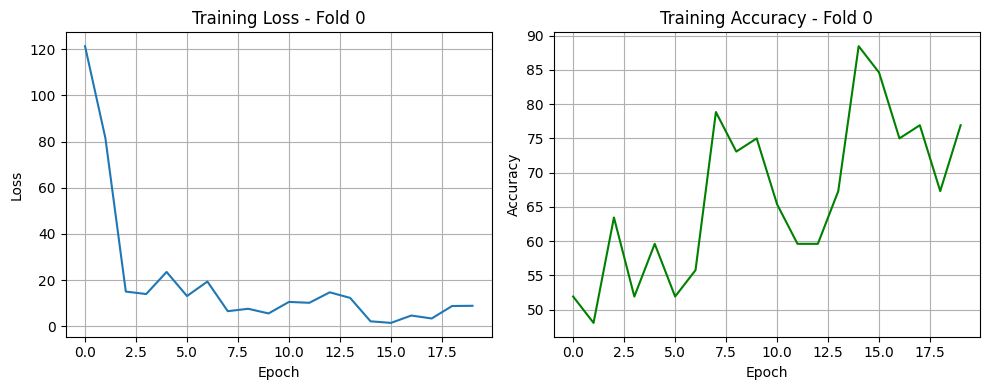

Fold 0 Validation Accuracy: 61.54%, Loss: 1.5081


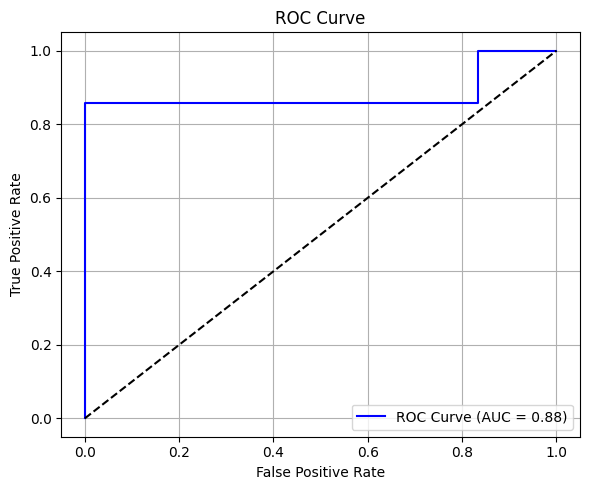


Sensitivity (Recall): 1.0000
Specificity         : 0.1667

Confusion Matrix:
 [[1 5]
 [0 7]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       1.00      0.17      0.29         6
      murmur       0.58      1.00      0.74         7

    accuracy                           0.62        13
   macro avg       0.79      0.58      0.51        13
weighted avg       0.78      0.62      0.53        13


Fold 1
Epoch [1/20] Loss: 36.3510, Accuracy: 48.08%
Epoch [2/20] Loss: 51.9653, Accuracy: 51.92%
Epoch [3/20] Loss: 58.0173, Accuracy: 50.00%
Epoch [4/20] Loss: 68.1551, Accuracy: 51.92%
Epoch [5/20] Loss: 32.2752, Accuracy: 51.92%
Epoch [6/20] Loss: 22.6497, Accuracy: 76.92%
Epoch [7/20] Loss: 30.6202, Accuracy: 71.15%
Epoch [8/20] Loss: 20.3107, Accuracy: 75.00%
Epoch [9/20] Loss: 7.0119, Accuracy: 80.77%
Epoch [10/20] Loss: 5.5806, Accuracy: 84.62%
Epoch [11/20] Loss: 3.1772, Accuracy: 78.85%
Epoch [12/20] Loss: 7.5294, Accuracy: 73.08%
Epoch [

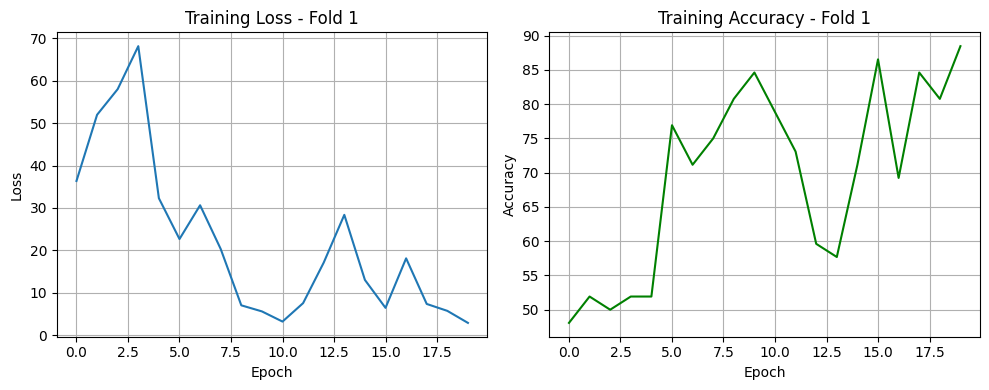

Fold 1 Validation Accuracy: 69.23%, Loss: 2.9223


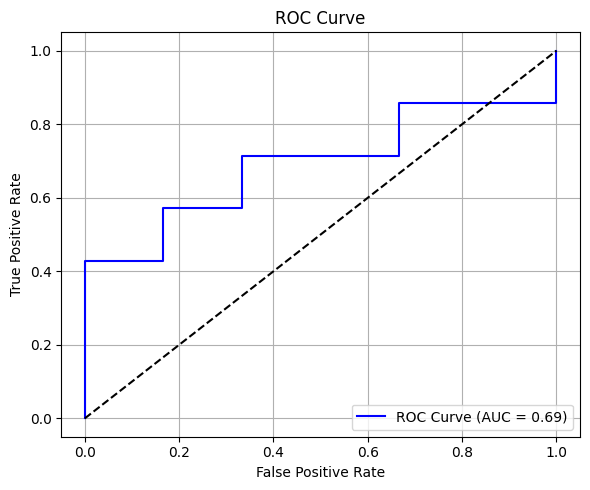


Sensitivity (Recall): 0.5714
Specificity         : 0.8333

Confusion Matrix:
 [[5 1]
 [3 4]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       0.62      0.83      0.71         6
      murmur       0.80      0.57      0.67         7

    accuracy                           0.69        13
   macro avg       0.71      0.70      0.69        13
weighted avg       0.72      0.69      0.69        13


Fold 2
Epoch [1/20] Loss: 43.8617, Accuracy: 51.92%
Epoch [2/20] Loss: 21.2356, Accuracy: 59.62%
Epoch [3/20] Loss: 14.0337, Accuracy: 63.46%
Epoch [4/20] Loss: 18.6521, Accuracy: 53.85%
Epoch [5/20] Loss: 22.3862, Accuracy: 53.85%
Epoch [6/20] Loss: 16.8270, Accuracy: 71.15%
Epoch [7/20] Loss: 10.7760, Accuracy: 82.69%
Epoch [8/20] Loss: 5.1891, Accuracy: 82.69%
Epoch [9/20] Loss: 4.6511, Accuracy: 86.54%
Epoch [10/20] Loss: 3.9993, Accuracy: 76.92%
Epoch [11/20] Loss: 2.6800, Accuracy: 84.62%
Epoch [12/20] Loss: 1.0737, Accuracy: 88.46%
Epoch [1

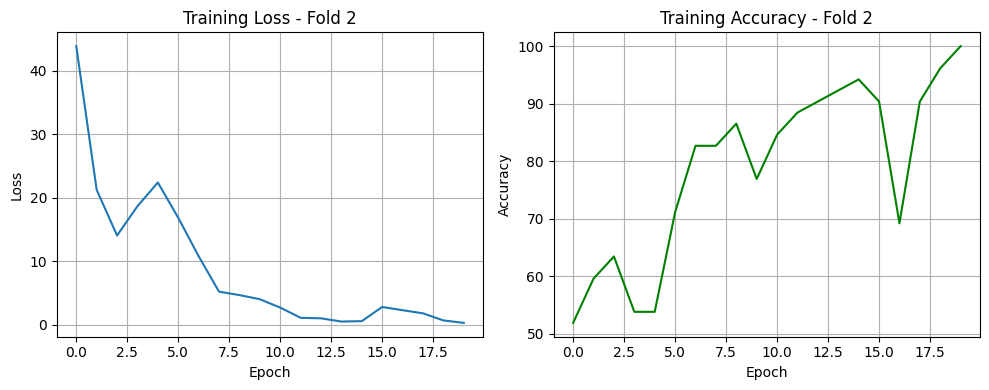

Fold 2 Validation Accuracy: 69.23%, Loss: 0.8646


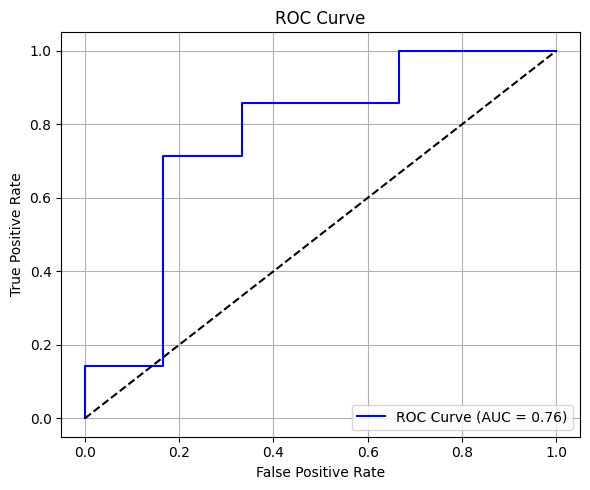


Sensitivity (Recall): 0.7143
Specificity         : 0.6667

Confusion Matrix:
 [[4 2]
 [2 5]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       0.67      0.67      0.67         6
      murmur       0.71      0.71      0.71         7

    accuracy                           0.69        13
   macro avg       0.69      0.69      0.69        13
weighted avg       0.69      0.69      0.69        13


Fold 3
Epoch [1/20] Loss: 35.4114, Accuracy: 46.15%
Epoch [2/20] Loss: 11.4930, Accuracy: 55.77%
Epoch [3/20] Loss: 11.7377, Accuracy: 67.31%
Epoch [4/20] Loss: 6.6037, Accuracy: 53.85%
Epoch [5/20] Loss: 6.1727, Accuracy: 67.31%
Epoch [6/20] Loss: 2.5794, Accuracy: 75.00%
Epoch [7/20] Loss: 3.0578, Accuracy: 59.62%
Epoch [8/20] Loss: 1.7914, Accuracy: 82.69%
Epoch [9/20] Loss: 1.5370, Accuracy: 88.46%
Epoch [10/20] Loss: 1.0816, Accuracy: 86.54%
Epoch [11/20] Loss: 1.2716, Accuracy: 88.46%
Epoch [12/20] Loss: 1.4350, Accuracy: 90.38%
Epoch [13/20

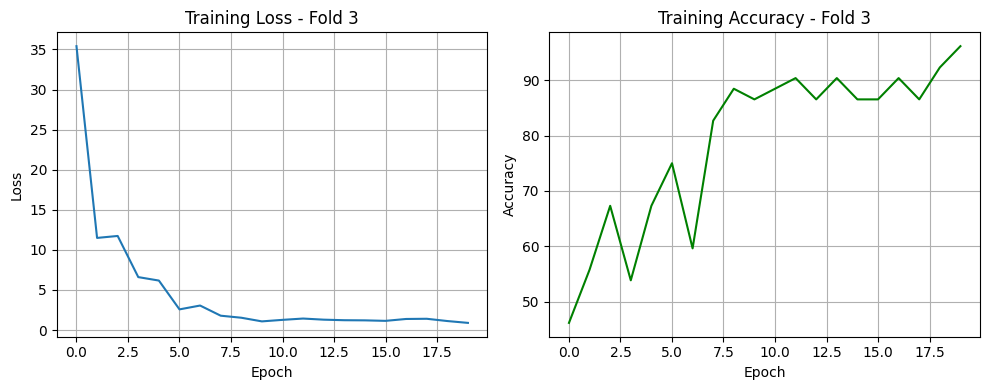

Fold 3 Validation Accuracy: 53.85%, Loss: 0.9074


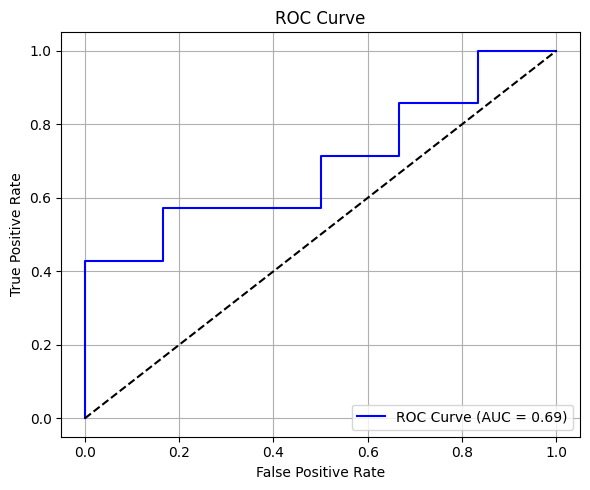


Sensitivity (Recall): 0.7143
Specificity         : 0.3333

Confusion Matrix:
 [[2 4]
 [2 5]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       0.50      0.33      0.40         6
      murmur       0.56      0.71      0.62         7

    accuracy                           0.54        13
   macro avg       0.53      0.52      0.51        13
weighted avg       0.53      0.54      0.52        13


Fold 4
Epoch [1/20] Loss: 34.3626, Accuracy: 53.85%
Epoch [2/20] Loss: 3.2937, Accuracy: 46.15%
Epoch [3/20] Loss: 2.4649, Accuracy: 71.15%
Epoch [4/20] Loss: 2.5937, Accuracy: 71.15%
Epoch [5/20] Loss: 2.0666, Accuracy: 71.15%
Epoch [6/20] Loss: 1.5221, Accuracy: 82.69%
Epoch [7/20] Loss: 1.7137, Accuracy: 90.38%
Epoch [8/20] Loss: 1.3198, Accuracy: 84.62%
Epoch [9/20] Loss: 1.9627, Accuracy: 76.92%
Epoch [10/20] Loss: 1.3962, Accuracy: 80.77%
Epoch [11/20] Loss: 1.8774, Accuracy: 82.69%
Epoch [12/20] Loss: 0.6208, Accuracy: 94.23%
Epoch [13/20] 

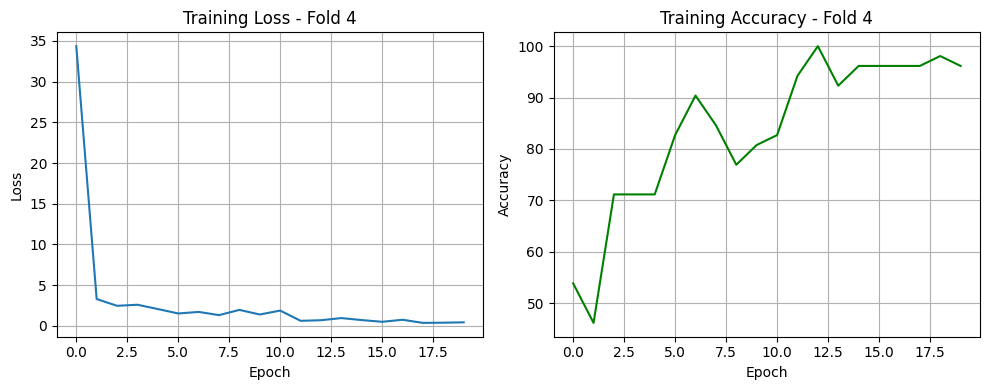

Fold 4 Validation Accuracy: 69.23%, Loss: 0.7227


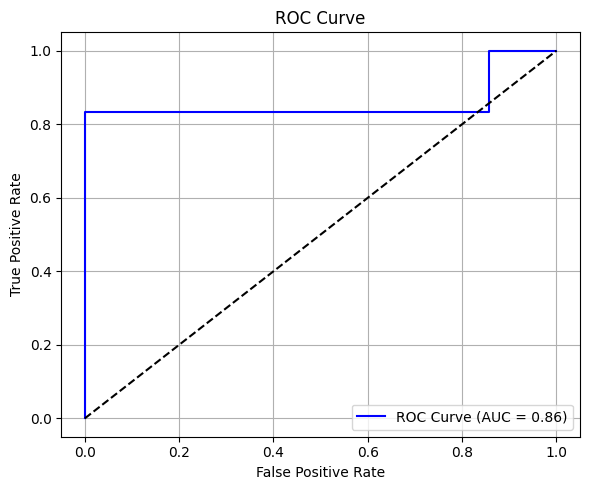


Sensitivity (Recall): 0.8333
Specificity         : 0.5714

Confusion Matrix:
 [[4 3]
 [1 5]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       0.80      0.57      0.67         7
      murmur       0.62      0.83      0.71         6

    accuracy                           0.69        13
   macro avg       0.71      0.70      0.69        13
weighted avg       0.72      0.69      0.69        13



In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor, y_tensor)):
    print(f"\nFold {fold}")

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_tensor[train_idx], y_tensor[train_idx]), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_tensor[val_idx], y_tensor[val_idx]), batch_size=16)

    # Model, loss, optimizer
    model = LeNet1().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    train_losses, train_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        train_losses.append(running_loss)
        train_accuracies.append(acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")

    # Plot training metrics
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title(f"Training Loss - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='green')
    plt.title(f"Training Accuracy - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()

    plt.tight_layout()
    plt.show()

    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    test_loss=0
    with torch.no_grad():
      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)

          # Compute loss
          loss = criterion(outputs, labels)
          test_loss += loss.item()

          # Predictions and probabilities
          probs = F.softmax(outputs, dim=1)[:, 1]  # Prob for class 1
          _, predicted = outputs.max(1)

          all_preds.extend(predicted.cpu().numpy())
          all_probs.extend(probs.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())
    avg_val_loss = test_loss / len(val_loader)
    val_acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    avg_accuracies.append(val_acc)
    avg_val_losses.append(avg_val_loss)
    print(f"Fold {fold} Validation Accuracy: {val_acc:.2f}%, Loss: {avg_val_loss:.4f}")
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # ROC and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 9. Metrics
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['non murmur', 'murmur'])
    TN, FP, FN, TP = cm.ravel()

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # also recall
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # true negative rate
    precision=TP/(TP+FP) if (TP+FP)>0 else 0.0
    f1_score=2*precision*sensitivity/(precision+sensitivity) if (precision+sensitivity)>0 else 0.0
    avg_f1_score.append(f1_score)
    avg_sensitivity.append(sensitivity)
    avg_specificity.append(specificity)
    avg_precision.append(precision)

    print(f"\nSensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity         : {specificity:.4f}")
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)
    print("=======================================================================================================================")

In [ ]:
print("\n fold wise metrics accross all folds")
for i in range(len(avg_accuracies)):
  print(f"FOLD{i}\n")
  print(f"Accuracy: {avg_accuracies[i]:.2f}%")
  print(f"Loss: {avg_val_losses[i]:.4f}")
  print(f"Precision: {avg_precision[i]:.4f}")
  print(f"Sensitivity: {avg_sensitivity[i]:.4f}")
  print(f"Specificity: {avg_specificity[i]:.4f}")
  print(f"F1 Score: {avg_f1_score[i]:.4f}")
  print("=======================================================================================================================")
print("\n Final Average Metrics Across All Folds:")
print(f"Average Accuracy   : {np.mean(avg_accuracies):.2f}%")
print(f"Average Loss       : {np.mean(avg_val_losses):.4f}")
print(f"Average Precision  : {np.mean(avg_precision):.4f}")
print(f"Average Recall     : {np.mean(avg_sensitivity):.4f}")
print(f"Average Specificity: {np.mean(avg_specificity):.4f}")
print(f"Average F1 Score   : {np.mean(avg_f1_score):.4f}")


 fold wise metrics accross all folds
FOLD0

Accuracy: 61.54%
Loss: 1.5081
Precision: 0.5833
Sensitivity: 1.0000
Specificity: 0.1667
F1 Score: 0.7368
FOLD1

Accuracy: 69.23%
Loss: 2.9223
Precision: 0.8000
Sensitivity: 0.5714
Specificity: 0.8333
F1 Score: 0.6667
FOLD2

Accuracy: 69.23%
Loss: 0.8646
Precision: 0.7143
Sensitivity: 0.7143
Specificity: 0.6667
F1 Score: 0.7143
FOLD3

Accuracy: 53.85%
Loss: 0.9074
Precision: 0.5556
Sensitivity: 0.7143
Specificity: 0.3333
F1 Score: 0.6250
FOLD4

Accuracy: 69.23%
Loss: 0.7227
Precision: 0.6250
Sensitivity: 0.8333
Specificity: 0.5714
F1 Score: 0.7143

 Final Average Metrics Across All Folds:
Average Accuracy   : 64.62%
Average Loss       : 1.3850
Average Precision  : 0.6556
Average Recall     : 0.7667
Average Specificity: 0.5143
Average F1 Score   : 0.6914


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

class LeNet5(nn.Module):
  def __init__(self,num_classes=2):
    super(LeNet5,self).__init__()

    self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
    self.pool1=nn.AvgPool2d(kernel_size=2,stride=2)

    self.conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
    self.pool2=nn.AvgPool2d(kernel_size=2,stride=2)

    self.conv3=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)

    self.fc1=nn.Linear(in_features=120*25*68,out_features=84)
    self.fc2=nn.Linear(in_features=84,out_features=num_classes)

  def forward(self,x):
    out=F.relu(self.conv1(x))
    out=self.pool1(out)

    out=F.relu(self.conv2(out))
    out=self.pool2(out)

    out=F.relu(self.conv3(out))

    out=out.reshape(out.size(0),-1)

    out=F.relu(self.fc1(out))
    out=self.fc2(out)
    return out

In [ ]:
X = np.load('/content/sample_data/X.npy')  # (N, 128, 300, 1)
y = np.load('/content/sample_data/y.npy')
X = np.transpose(X, (0, 3, 1, 2))           # (N, 1, 128, 300)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
num_epochs = 15
avg_accuracies = []
avg_val_losses=[]
avg_f1_score=[]
avg_sensitivity=[]
avg_specificity=[]
avg_precision=[]


Fold 0
Epoch [1/15] Loss: 536.1600, Accuracy: 40.38%
Epoch [2/15] Loss: 10.4519, Accuracy: 51.92%
Epoch [3/15] Loss: 3.1323, Accuracy: 59.62%
Epoch [4/15] Loss: 2.5050, Accuracy: 67.31%
Epoch [5/15] Loss: 1.7906, Accuracy: 80.77%
Epoch [6/15] Loss: 1.4357, Accuracy: 82.69%
Epoch [7/15] Loss: 1.7243, Accuracy: 86.54%
Epoch [8/15] Loss: 1.4128, Accuracy: 84.62%
Epoch [9/15] Loss: 1.2972, Accuracy: 84.62%
Epoch [10/15] Loss: 1.2854, Accuracy: 86.54%
Epoch [11/15] Loss: 1.0561, Accuracy: 90.38%
Epoch [12/15] Loss: 0.9918, Accuracy: 90.38%
Epoch [13/15] Loss: 1.4372, Accuracy: 88.46%
Epoch [14/15] Loss: 1.0356, Accuracy: 88.46%
Epoch [15/15] Loss: 1.0464, Accuracy: 90.38%


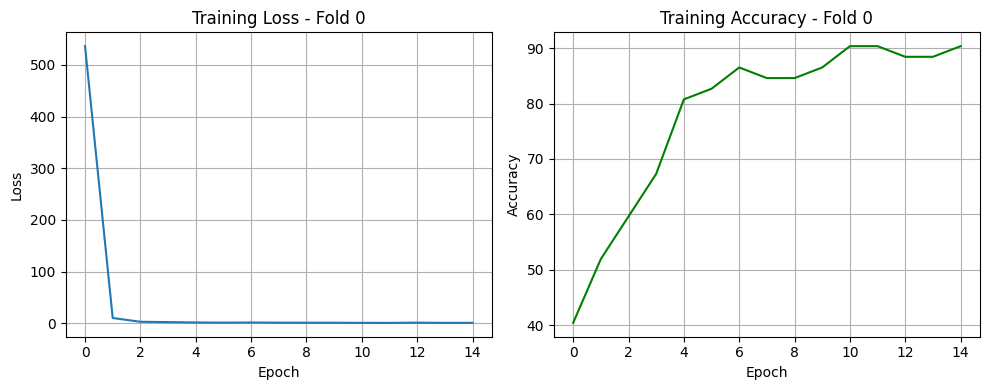

Fold 0 Validation Accuracy: 61.54%, Loss: 1.3189


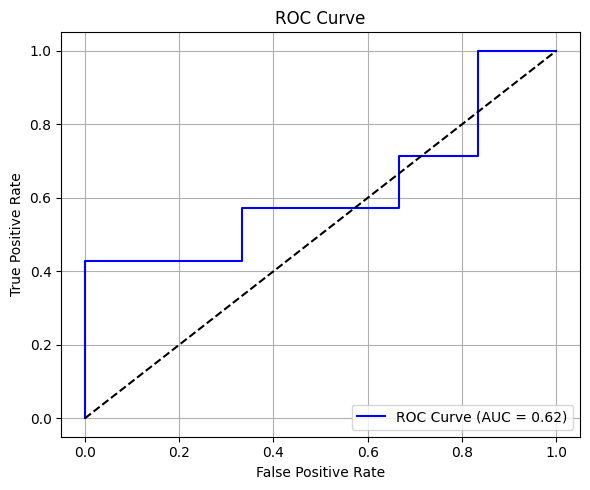


Sensitivity (Recall): 0.5714
Specificity         : 0.6667

Confusion Matrix:
 [[4 2]
 [3 4]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       0.57      0.67      0.62         6
      murmur       0.67      0.57      0.62         7

    accuracy                           0.62        13
   macro avg       0.62      0.62      0.62        13
weighted avg       0.62      0.62      0.62        13


Fold 1
Epoch [1/15] Loss: 503.8890, Accuracy: 44.23%
Epoch [2/15] Loss: 108.9417, Accuracy: 50.00%
Epoch [3/15] Loss: 25.4100, Accuracy: 53.85%
Epoch [4/15] Loss: 17.0085, Accuracy: 50.00%
Epoch [5/15] Loss: 2.9089, Accuracy: 61.54%
Epoch [6/15] Loss: 1.5419, Accuracy: 88.46%
Epoch [7/15] Loss: 1.7145, Accuracy: 84.62%
Epoch [8/15] Loss: 1.1910, Accuracy: 90.38%
Epoch [9/15] Loss: 3.1717, Accuracy: 80.77%
Epoch [10/15] Loss: 1.5620, Accuracy: 84.62%
Epoch [11/15] Loss: 3.3777, Accuracy: 90.38%
Epoch [12/15] Loss: 1.4942, Accuracy: 90.38%
Epoch [13

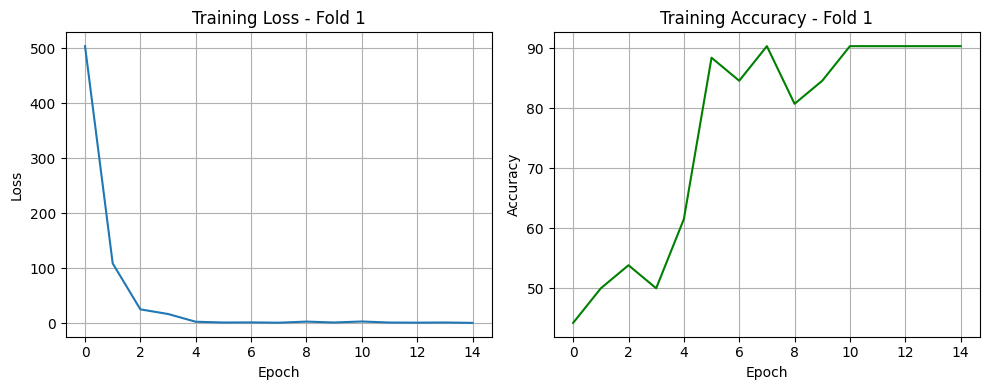

Fold 1 Validation Accuracy: 46.15%, Loss: 2.0608


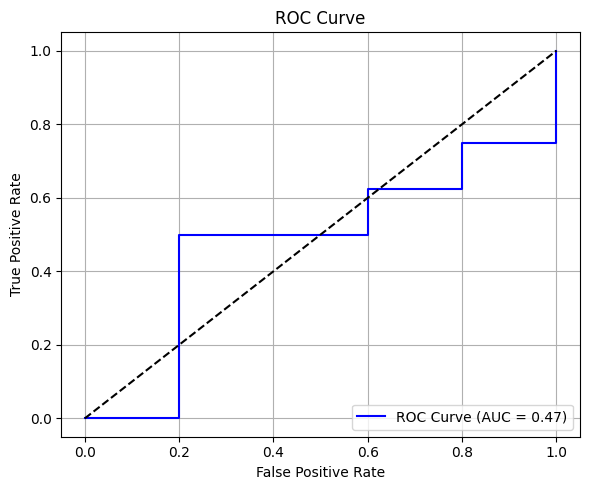


Sensitivity (Recall): 0.5000
Specificity         : 0.4000

Confusion Matrix:
 [[2 3]
 [4 4]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       0.33      0.40      0.36         5
      murmur       0.57      0.50      0.53         8

    accuracy                           0.46        13
   macro avg       0.45      0.45      0.45        13
weighted avg       0.48      0.46      0.47        13


Fold 2
Epoch [1/15] Loss: 18.0216, Accuracy: 61.54%
Epoch [2/15] Loss: 19.3442, Accuracy: 46.15%
Epoch [3/15] Loss: 2.2755, Accuracy: 61.54%
Epoch [4/15] Loss: 2.1134, Accuracy: 78.85%
Epoch [5/15] Loss: 2.5612, Accuracy: 84.62%
Epoch [6/15] Loss: 1.4501, Accuracy: 86.54%
Epoch [7/15] Loss: 1.3199, Accuracy: 86.54%
Epoch [8/15] Loss: 1.0886, Accuracy: 86.54%
Epoch [9/15] Loss: 0.9725, Accuracy: 86.54%
Epoch [10/15] Loss: 1.8080, Accuracy: 88.46%
Epoch [11/15] Loss: 0.7804, Accuracy: 92.31%
Epoch [12/15] Loss: 0.9437, Accuracy: 94.23%
Epoch [13/15]

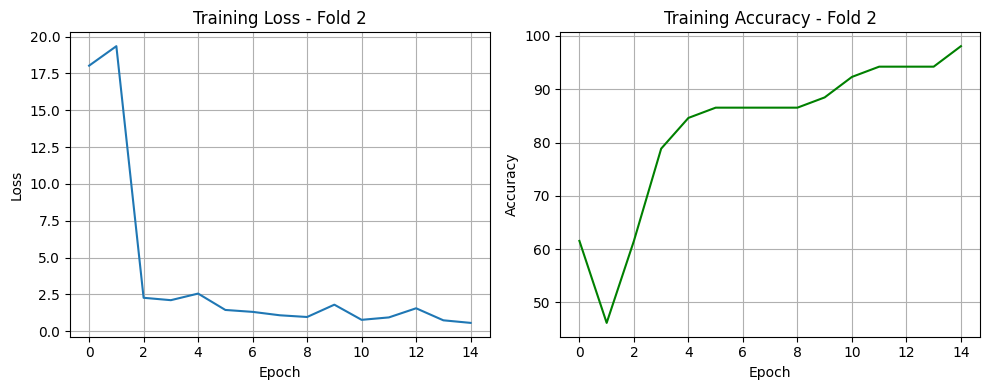

Fold 2 Validation Accuracy: 92.31%, Loss: 0.2166


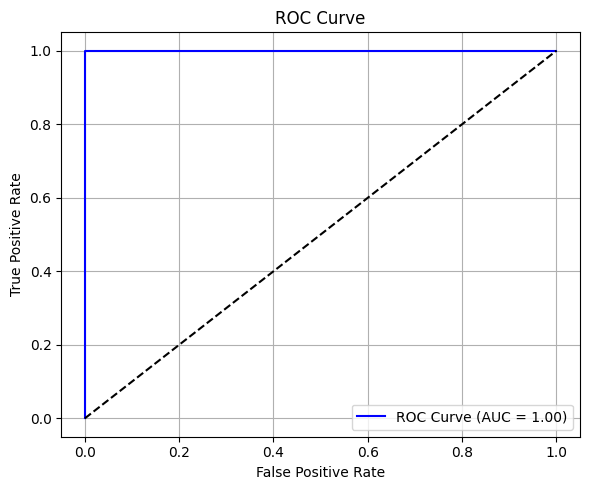


Sensitivity (Recall): 1.0000
Specificity         : 0.8571

Confusion Matrix:
 [[6 1]
 [0 6]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       1.00      0.86      0.92         7
      murmur       0.86      1.00      0.92         6

    accuracy                           0.92        13
   macro avg       0.93      0.93      0.92        13
weighted avg       0.93      0.92      0.92        13


Fold 3
Epoch [1/15] Loss: 286.2868, Accuracy: 48.08%
Epoch [2/15] Loss: 121.3448, Accuracy: 44.23%
Epoch [3/15] Loss: 34.7928, Accuracy: 67.31%
Epoch [4/15] Loss: 13.7658, Accuracy: 59.62%
Epoch [5/15] Loss: 7.5619, Accuracy: 80.77%
Epoch [6/15] Loss: 3.9497, Accuracy: 57.69%
Epoch [7/15] Loss: 4.3125, Accuracy: 80.77%
Epoch [8/15] Loss: 1.9825, Accuracy: 75.00%
Epoch [9/15] Loss: 1.9350, Accuracy: 75.00%
Epoch [10/15] Loss: 1.2148, Accuracy: 80.77%
Epoch [11/15] Loss: 6.6840, Accuracy: 61.54%
Epoch [12/15] Loss: 2.2833, Accuracy: 69.23%
Epoch [13

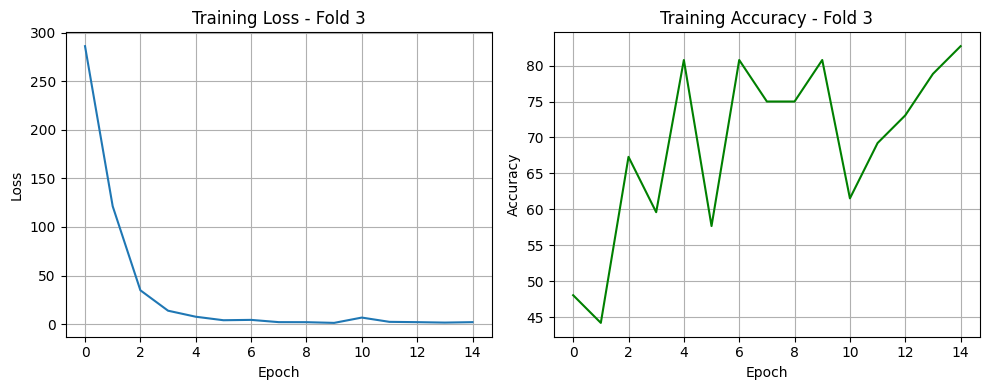

Fold 3 Validation Accuracy: 76.92%, Loss: 0.4980


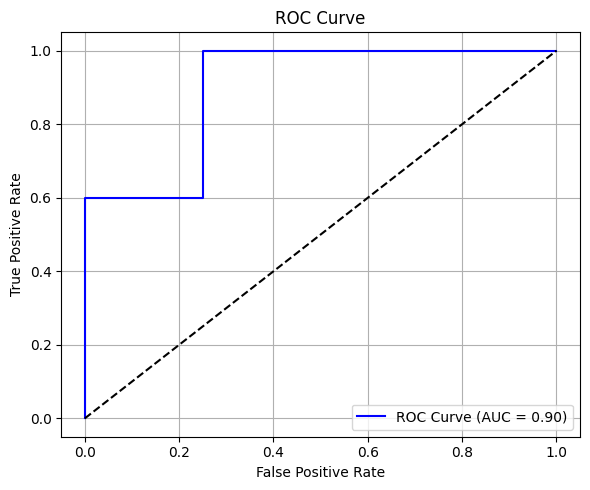


Sensitivity (Recall): 0.6000
Specificity         : 0.8750

Confusion Matrix:
 [[7 1]
 [2 3]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       0.78      0.88      0.82         8
      murmur       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13


Fold 4
Epoch [1/15] Loss: 145.1710, Accuracy: 51.92%
Epoch [2/15] Loss: 49.8106, Accuracy: 50.00%
Epoch [3/15] Loss: 10.8043, Accuracy: 50.00%
Epoch [4/15] Loss: 3.6436, Accuracy: 73.08%
Epoch [5/15] Loss: 1.6982, Accuracy: 80.77%
Epoch [6/15] Loss: 2.1514, Accuracy: 76.92%
Epoch [7/15] Loss: 1.7721, Accuracy: 67.31%
Epoch [8/15] Loss: 1.4814, Accuracy: 84.62%
Epoch [9/15] Loss: 0.9782, Accuracy: 86.54%
Epoch [10/15] Loss: 1.0407, Accuracy: 90.38%
Epoch [11/15] Loss: 0.6923, Accuracy: 98.08%
Epoch [12/15] Loss: 0.3742, Accuracy: 98.08%
Epoch [13/1

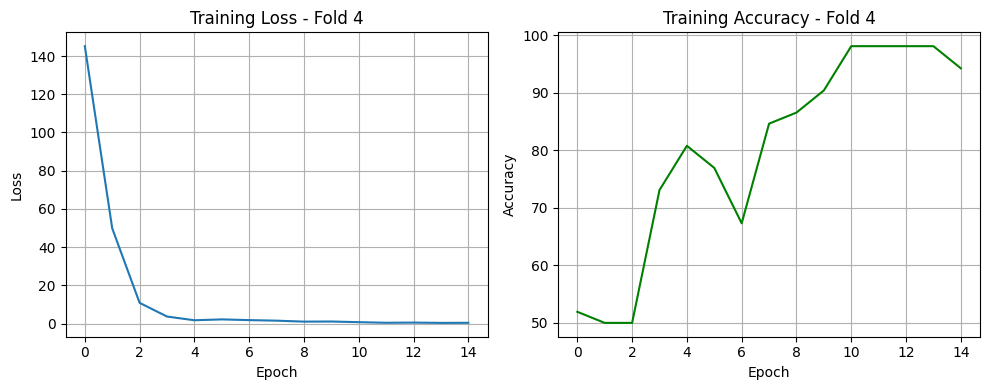

Fold 4 Validation Accuracy: 76.92%, Loss: 0.4513


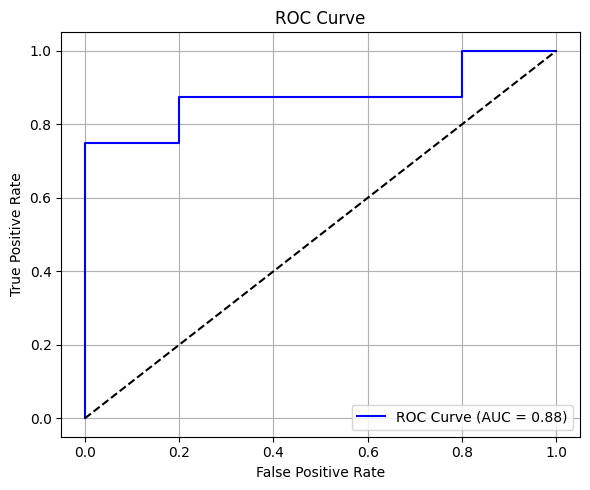


Sensitivity (Recall): 0.7500
Specificity         : 0.8000

Confusion Matrix:
 [[4 1]
 [2 6]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       0.67      0.80      0.73         5
      murmur       0.86      0.75      0.80         8

    accuracy                           0.77        13
   macro avg       0.76      0.78      0.76        13
weighted avg       0.78      0.77      0.77        13



In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor, y_tensor)):
    print(f"\nFold {fold}")

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_tensor[train_idx], y_tensor[train_idx]), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_tensor[val_idx], y_tensor[val_idx]), batch_size=16)

    # Model, loss, optimizer
    model = LeNet5().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    train_losses, train_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        train_losses.append(running_loss)
        train_accuracies.append(acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")

    # Plot training metrics
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title(f"Training Loss - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='green')
    plt.title(f"Training Accuracy - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()

    plt.tight_layout()
    plt.show()

    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    test_loss=0
    with torch.no_grad():
      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)

          # Compute loss
          loss = criterion(outputs, labels)
          test_loss += loss.item()

          # Predictions and probabilities
          probs = F.softmax(outputs, dim=1)[:, 1]  # Prob for class 1
          _, predicted = outputs.max(1)

          all_preds.extend(predicted.cpu().numpy())
          all_probs.extend(probs.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())
    avg_val_loss = test_loss / len(val_loader)
    val_acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    avg_accuracies.append(val_acc)
    avg_val_losses.append(avg_val_loss)
    print(f"Fold {fold} Validation Accuracy: {val_acc:.2f}%, Loss: {avg_val_loss:.4f}")
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # ROC and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 9. Metrics
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['non murmur', 'murmur'])
    TN, FP, FN, TP = cm.ravel()

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # also recall
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # true negative rate
    precision=TP/(TP+FP) if (TP+FP)>0 else 0.0
    f1_score=2*precision*sensitivity/(precision+sensitivity) if (precision+sensitivity)>0 else 0.0
    avg_f1_score.append(f1_score)
    avg_sensitivity.append(sensitivity)
    avg_specificity.append(specificity)
    avg_precision.append(precision)

    print(f"\nSensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity         : {specificity:.4f}")
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)
    print("=======================================================================================================================")



In [ ]:
print("\n fold wise metrics accross all folds")
for i in range(len(avg_accuracies)):
  print(f"FOLD{i}\n")
  print(f"Accuracy: {avg_accuracies[i]:.2f}%")
  print(f"Loss: {avg_val_losses[i]:.4f}")
  print(f"Precision: {avg_precision[i]:.4f}")
  print(f"Sensitivity: {avg_sensitivity[i]:.4f}")
  print(f"Specificity: {avg_specificity[i]:.4f}")
  print(f"F1 Score: {avg_f1_score[i]:.4f}")
  print("=======================================================================================================================")
print("\n Final Average Metrics Across All Folds:")
print(f"Average Accuracy   : {np.mean(avg_accuracies):.2f}%")
print(f"Average Loss       : {np.mean(avg_val_losses):.4f}")
print(f"Average Precision  : {np.mean(avg_precision):.4f}")
print(f"Average Recall     : {np.mean(avg_sensitivity):.4f}")
print(f"Average Specificity: {np.mean(avg_specificity):.4f}")
print(f"Average F1 Score   : {np.mean(avg_f1_score):.4f}")


 fold wise metrics accross all folds
FOLD0

Accuracy: 61.54%
Loss: 1.3189
Precision: 0.6667
Sensitivity: 0.5714
Specificity: 0.6667
F1 Score: 0.6154
FOLD1

Accuracy: 46.15%
Loss: 2.0608
Precision: 0.5714
Sensitivity: 0.5000
Specificity: 0.4000
F1 Score: 0.5333
FOLD2

Accuracy: 92.31%
Loss: 0.2166
Precision: 0.8571
Sensitivity: 1.0000
Specificity: 0.8571
F1 Score: 0.9231
FOLD3

Accuracy: 76.92%
Loss: 0.4980
Precision: 0.7500
Sensitivity: 0.6000
Specificity: 0.8750
F1 Score: 0.6667
FOLD4

Accuracy: 76.92%
Loss: 0.4513
Precision: 0.8571
Sensitivity: 0.7500
Specificity: 0.8000
F1 Score: 0.8000

 Final Average Metrics Across All Folds:
Average Accuracy   : 70.77%
Average Loss       : 0.9091
Average Precision  : 0.7405
Average Recall     : 0.6843
Average Specificity: 0.7198
Average F1 Score   : 0.7077
